<a href="https://colab.research.google.com/github/hyejwon/1_ne/blob/main/%EA%B3%BC%EB%8C%80%EC%A0%81%ED%95%A9%EA%B3%BC_%EA%B3%BC%EC%86%8C%EC%A0%81%ED%95%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras 

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) #파이썬 버전 출력

2.4.1


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
tf.test.gpu_device_name()

''

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1864518557533794806
]


IMDB 데이터셋 다운로드
이전 노트북에서처럼 임베딩을 사용하지 않고 여기에서는 문장을 멀티-핫 인코딩(multi-hot encoding)으로 변환하겠습니다. 이 모델은 훈련 세트에 빠르게 과대적합될 것입니다. 과대적합을 발생시키기고 어떻게 해결하는지 보이기 위해 선택했습니다.

멀티-핫 인코딩은 정수 시퀀스를 0과 1로 이루어진 벡터로 변환합니다. 정확하게 말하면 시퀀스 [3, 5]를 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000 차원 벡터로 변환한다는 의미입니다.

In [ ]:
NUM_WORDS = 10000
(train_data, train_labels),(test_data,test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences,dimension):
    results= np.zeros((len(sequences),dimension)) #0으로 채워진 (len(sequences),dimension)크기의 행렬 생성
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0 #results[1]의 특정 인덱스만 1로 설정
    return results


train_data = multi_hot_sequences(train_data, dimension = NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension = NUM_WORDS)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
#enumerate() 예제 
t = [1, 5, 7, 33, 39, 52] # list 생성
for p in enumerate(t):
    print(p)



(0, 1)
(1, 5)
(2, 7)
(3, 33)
(4, 39)
(5, 52)


In [ ]:
for i,v in enumerate(t):
    print("index : {}, value: {}".format(i,v))

index : 0, value: 1
index : 1, value: 5
index : 2, value: 7
index : 3, value: 33
index : 4, value: 39
index : 5, value: 52


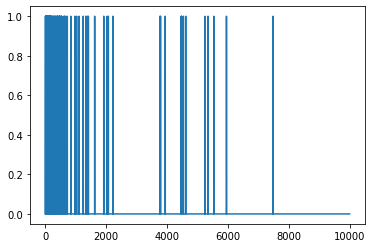

In [ ]:
plt.plot(train_data[0])

## 과대적합 예제  
과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량"이라고 말합니다. 직관적으로 생각해 보면 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.

항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.

반면에 네트워크의 기억 용량이 부족하다면 이런 매핑을 쉽게 학습할 수 없을 것입니다. 손실을 최소화하기 위해서는 예측 성능이 더 많은 압축된 표현을 학습해야 합니다. 또한 너무 작은 모델을 만들면 훈련 데이터를 학습하기 어렵울 것입니다. "너무 많은 용량"과 "충분하지 않은 용량" 사이의 균형을 잡아야 합니다.

안타깝지만 어떤 모델의 (층의 개수나 뉴런 개수에 해당하는) 적절한 크기나 구조를 결정하는 마법같은 공식은 없습니다. 여러 가지 다른 구조를 사용해 실험을 해봐야만 합니다.

알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다. 영화 리뷰 분류 네트워크를 사용해 이를 실험해 보죠.

Dense 층만 사용하는 간단한 기준 모델을 만들고 작은 규모의 버전와 큰 버전의 모델을 만들어 비교하겠습니다.

In [ ]:
#기준 모델 만들기
baseline_model = keras.Sequential([
    #'.summary' 메서드 때문에 'input_shape'가 필요
    keras.layers.Dense(16, activation='relu',input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy','binary_crossentropy'])
baseline_model.summary()#모델에 대한 요약 정보

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_history = baseline_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data,test_labels),
                                    verbose=2) 

Epoch 1/20
49/49 - 3s - loss: 0.4861 - accuracy: 0.7994 - binary_crossentropy: 0.4861 - val_loss: 0.3394 - val_accuracy: 0.8774 - val_binary_crossentropy: 0.3394
Epoch 2/20
49/49 - 2s - loss: 0.2520 - accuracy: 0.9108 - binary_crossentropy: 0.2520 - val_loss: 0.2856 - val_accuracy: 0.8875 - val_binary_crossentropy: 0.2856
Epoch 3/20
49/49 - 2s - loss: 0.1850 - accuracy: 0.9339 - binary_crossentropy: 0.1850 - val_loss: 0.2883 - val_accuracy: 0.8859 - val_binary_crossentropy: 0.2883
Epoch 4/20
49/49 - 2s - loss: 0.1493 - accuracy: 0.9494 - binary_crossentropy: 0.1493 - val_loss: 0.3100 - val_accuracy: 0.8799 - val_binary_crossentropy: 0.3100
Epoch 5/20
49/49 - 2s - loss: 0.1205 - accuracy: 0.9610 - binary_crossentropy: 0.1205 - val_loss: 0.3335 - val_accuracy: 0.8758 - val_binary_crossentropy: 0.3335
Epoch 6/20
49/49 - 2s - loss: 0.1001 - accuracy: 0.9692 - binary_crossentropy: 0.1001 - val_loss: 0.3649 - val_accuracy: 0.8717 - val_binary_crossentropy: 0.3649
Epoch 7/20
49/49 - 2s - loss

In [ ]:
#작은 모델 만들기
smaller_model = keras.Sequential([
    #'.summary' 메서드 때문에 'input_shape'가 필요
    keras.layers.Dense(4, activation='relu',input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy','binary_crossentropy'])
smaller_model.summary()#모델에 대한 요약 정보

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data,test_labels),
                                    verbose=2) 

Epoch 1/20
49/49 - 3s - loss: 0.5936 - accuracy: 0.6974 - binary_crossentropy: 0.5936 - val_loss: 0.5210 - val_accuracy: 0.7977 - val_binary_crossentropy: 0.5210
Epoch 2/20
49/49 - 1s - loss: 0.4518 - accuracy: 0.8662 - binary_crossentropy: 0.4518 - val_loss: 0.4323 - val_accuracy: 0.8720 - val_binary_crossentropy: 0.4323
Epoch 3/20
49/49 - 2s - loss: 0.3497 - accuracy: 0.9087 - binary_crossentropy: 0.3497 - val_loss: 0.3548 - val_accuracy: 0.8767 - val_binary_crossentropy: 0.3548
Epoch 4/20
49/49 - 2s - loss: 0.2611 - accuracy: 0.9283 - binary_crossentropy: 0.2611 - val_loss: 0.3063 - val_accuracy: 0.8862 - val_binary_crossentropy: 0.3063
Epoch 5/20
49/49 - 2s - loss: 0.2038 - accuracy: 0.9389 - binary_crossentropy: 0.2038 - val_loss: 0.2931 - val_accuracy: 0.8858 - val_binary_crossentropy: 0.2931
Epoch 6/20
49/49 - 2s - loss: 0.1678 - accuracy: 0.9503 - binary_crossentropy: 0.1678 - val_loss: 0.2996 - val_accuracy: 0.8803 - val_binary_crossentropy: 0.2996
Epoch 7/20
49/49 - 2s - loss

In [ ]:
#큰 모델 만들기
bigger_model = keras.Sequential([
    #'.summary' 메서드 때문에 'input_shape'가 필요
    keras.layers.Dense(512, activation='relu',input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy','binary_crossentropy'])
bigger_model.summary()#모델에 대한 요약 정보

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bigger_history = bigger_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data,test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 15s - loss: 0.3414 - accuracy: 0.8583 - binary_crossentropy: 0.3414 - val_loss: 0.2906 - val_accuracy: 0.8822 - val_binary_crossentropy: 0.2906
Epoch 2/20
49/49 - 14s - loss: 0.1402 - accuracy: 0.9507 - binary_crossentropy: 0.1402 - val_loss: 0.3277 - val_accuracy: 0.8748 - val_binary_crossentropy: 0.3277
Epoch 3/20
49/49 - 14s - loss: 0.0482 - accuracy: 0.9863 - binary_crossentropy: 0.0482 - val_loss: 0.4367 - val_accuracy: 0.8696 - val_binary_crossentropy: 0.4367
Epoch 4/20
49/49 - 14s - loss: 0.0078 - accuracy: 0.9990 - binary_crossentropy: 0.0078 - val_loss: 0.5740 - val_accuracy: 0.8710 - val_binary_crossentropy: 0.5740
Epoch 5/20
49/49 - 14s - loss: 0.0013 - accuracy: 1.0000 - binary_crossentropy: 0.0013 - val_loss: 0.6692 - val_accuracy: 0.8714 - val_binary_crossentropy: 0.6692
Epoch 6/20
49/49 - 14s - loss: 2.5591e-04 - accuracy: 1.0000 - binary_crossentropy: 2.5591e-04 - val_loss: 0.7160 - val_accuracy: 0.8728 - val_binary_crossentropy: 0.7160
Epoch 7/20
49/

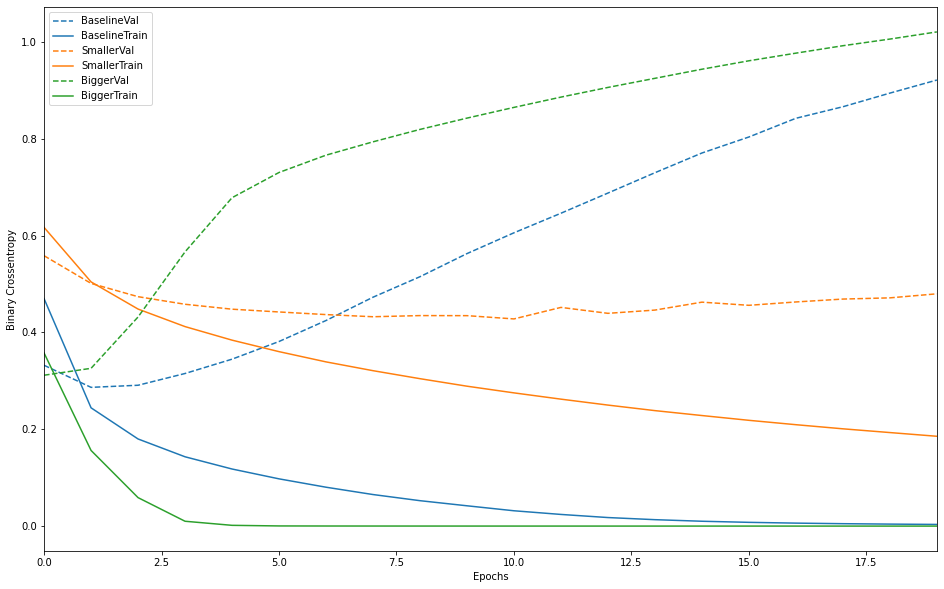

In [ ]:
def plot_history(histories,key ='binary_crossentropy'):
    plt.figure(figsize=(16,10))#그림 사이즈 인치 기준

    for name, history in histories:
        val = plt.plot(history.epoch, history.history ['val_'+key],
                       '--',label=name.title()+'Val')
        plt.plot(history.epoch,history.history[key],color=val[0].get_color(),
                 label=name.title()+'Train')
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())

        plt.legend()

        plt.xlim([0,max(history.epoch)])

plot_history([('baseline',baseline_history),
              ('smaller',smaller_history),
              ('bigger',bigger_history)])

over fitting -> bigger model 에서 심함(훈련 손실과 검증 손실 사이에 큰 차이가 발생함)

## 과대적합을 방지하기 위한 전략  

1. 가중치를 규제하기  
아마도 오캄의 면도날(Occam's Razor) 이론을 들어 보았을 것입니다. 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 "간단한" 설명일 것입니다. 이는 신경망으로 학습되는 모델에도 적용됩니다. 훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합(즉, 가능한 모델)은 많습니다. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것입니다.

    여기서 "간단한 모델"은 모델 파라미터의 분포를 봤을 때 엔트로피(entropy)가 작은 모델입니다(또는 앞 절에서 보았듯이 적은 파라미터를 가진 모델입니다). 따라서 과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것입니다. 이는 가중치 값의 분포를 좀 더 균일하게 만들어 줍니다. 이를 "가중치 규제"(weight regularization)라고 부릅니다. 네트워크의 손실 함수에 큰 가중치에 해당하는 비용을 추가합니다. 이 비용은 두 가지 형태가 있습니다:  

    L1 규제는 가중치의 절댓값에 비례하는 비용이 추가됩니다(즉, 가중치의 "L1 노름(norm)"을 추가합니다).

    L2 규제는 가중치의 제곱에 비례하는 비용이 추가됩니다(즉, 가중치의 "L2 노름"의 제곱을 추가합니다). 신경망에서는 L2 규제를 가중치 감쇠(weight decay)라고도 부릅니다. 이름이 다르지만 혼돈하지 마세요. 가중치 감쇠는 수학적으로 L2 규제와 동일합니다.

    L1 규제는 일부 가중치 파라미터를 0으로 만듭니다. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않습니다. 이것이 L2 규제를 더 많이 사용하는 이유 중 하나입니다.

    tf.keras에서는 가중치 규제 객체를 층의 키워드 매개변수에 전달하여 가중치에 규제를 추가합니다. L2 가중치 규제를 추가해 보죠.

In [ ]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),
                        activation='relu',input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),
                        activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy','binary_crossentropy'])

l2_model_history = l2_model.fit(train_data,train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data,test_labels),
                                verbose=2)

NameError: ignored

```l2(0.001)```는 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 ```0.001*weight_coefficient_value**2``` 만큼 더해진다는 의미  
이런 페널티는 훈련할 때만 추가된다. 따라서 테스트 단계보다 훈련 단계에서 네트워크 손실이 훨씬 더 클 것이다.


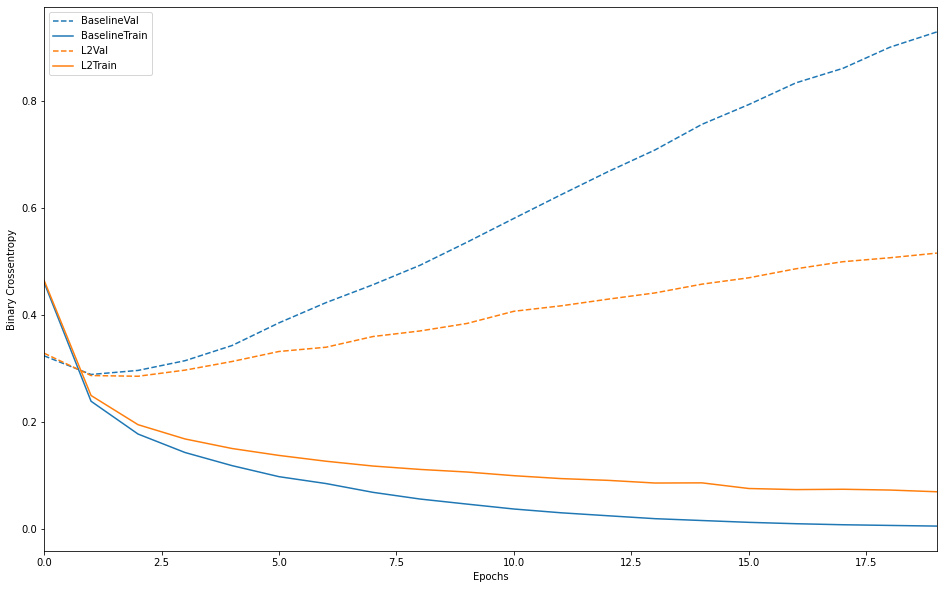

In [ ]:
#L2 규제의 효과를 확인
plot_history([('baseline',baseline_history),
              ('l2',l2_model_history)])

2. 드롭아웃 추가하기  
    드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

    tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다.

    IMDB 네트워크에 두 개의 Dropout 층을 추가하여 과대적합이 얼마나 감소하는지 알아 보겠습니다:

In [ ]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16,activation='relu',input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])
                                     
dpt_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data,train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data,test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 4s - loss: 0.6121 - accuracy: 0.6580 - binary_crossentropy: 0.6121 - val_loss: 0.4509 - val_accuracy: 0.8590 - val_binary_crossentropy: 0.4509
Epoch 2/20
49/49 - 2s - loss: 0.4435 - accuracy: 0.8146 - binary_crossentropy: 0.4435 - val_loss: 0.3354 - val_accuracy: 0.8833 - val_binary_crossentropy: 0.3354
Epoch 3/20
49/49 - 2s - loss: 0.3438 - accuracy: 0.8775 - binary_crossentropy: 0.3438 - val_loss: 0.2919 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.2919
Epoch 4/20
49/49 - 2s - loss: 0.2889 - accuracy: 0.9008 - binary_crossentropy: 0.2889 - val_loss: 0.2803 - val_accuracy: 0.8866 - val_binary_crossentropy: 0.2803
Epoch 5/20
49/49 - 2s - loss: 0.2501 - accuracy: 0.9179 - binary_crossentropy: 0.2501 - val_loss: 0.2834 - val_accuracy: 0.8871 - val_binary_crossentropy: 0.2834
Epoch 6/20
49/49 - 2s - loss: 0.2127 - accuracy: 0.9329 - binary_crossentropy: 0.2127 - val_loss: 0.3029 - val_accuracy: 0.8860 - val_binary_crossentropy: 0.3029
Epoch 7/20
49/49 - 2s - loss

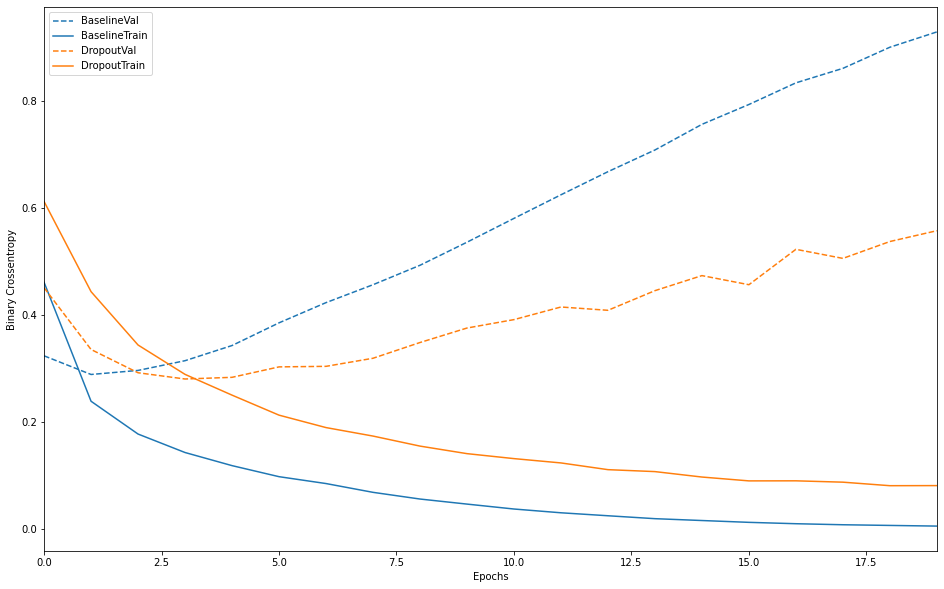

In [ ]:
plot_history([('baseline',baseline_history),
              ('dropout',dpt_model_history)])